# Goal
This project is intended find the best model to predict the plan of service at the phone company Megaline based on 4 features, calls, minutes, messages	and mb_used.

# Steps:

    - Descriptive statistics;
    - Data Preprocessing: missing values and duplicates check;
    - Check for outliers
    - Splitting data into train, validation and test sets;
    - Features scaling for outliers;
    - Models' hyperparameters tuning for logistic regression, decision tree and random forest;
    - Model selection;
    - Retrain the best tuned model on the whole training set and test it on the test set;
    - Sanity check.

# Data
Every observation in the dataset contains average monthly behavior information about one user. 

    - сalls — number of calls,
    - minutes — total call duration in minutes,
    - messages — number of text messages,
    - mb_used — Internet traffic used in MB,
    - is_ultra — plan for the current month (Ultra - 1, Surf - 0).

# Loading the packages

In [1]:
# for review
#!pip install yellowbrick --user

In [2]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler as ss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from yellowbrick.classifier import ClassificationReport

#%conda install -c districtdatalabs yellowbrick


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

#%pip install pingouin
#import pingouin as pg

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

pd.set_option('display.max_rows', None)

print("Setup Complete")

Setup Complete


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Pro tip: we can import whole metrics from sklearn (from sklearn import metrics).
</div>

# Loading the data

In [3]:
try:
    df = pd.read_csv('users_behavior.csv')
    
except:
    df = pd.read_csv('/datasets/users_behavior.csv')  

# Understanding the data

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
df.messages.value_counts().count()

180

In [8]:
df.duplicated().sum()

0

In [9]:
def show_hist_loat_chart(dataframe: pd.core.frame.DataFrame, column_name: float):
    hist_data = dataframe[column_name]

    hist_data.plot(
        kind='hist', density=True, figsize=(15, 5), rot=90, alpha=.5, fontsize=8
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f'  Distribution of {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=10)
    plt.xlabel(beautify_column_name, fontsize=10)

    plt.show()

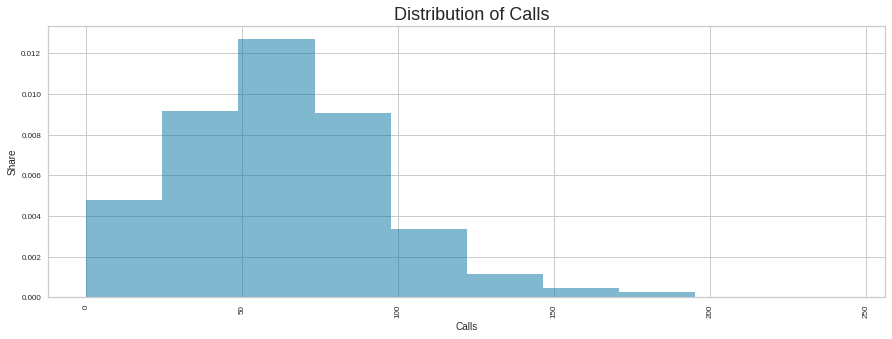

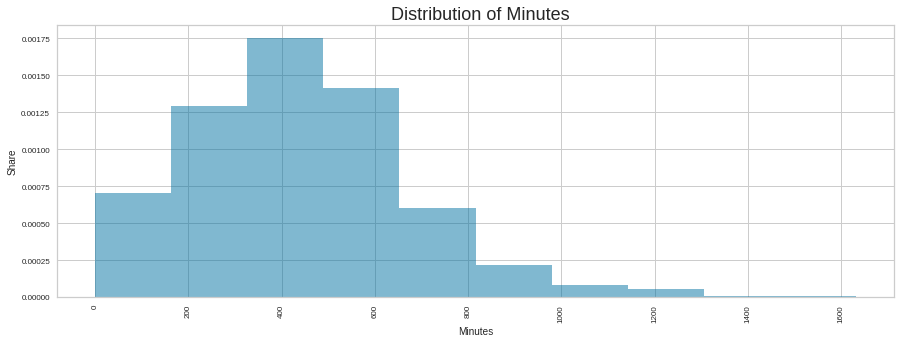

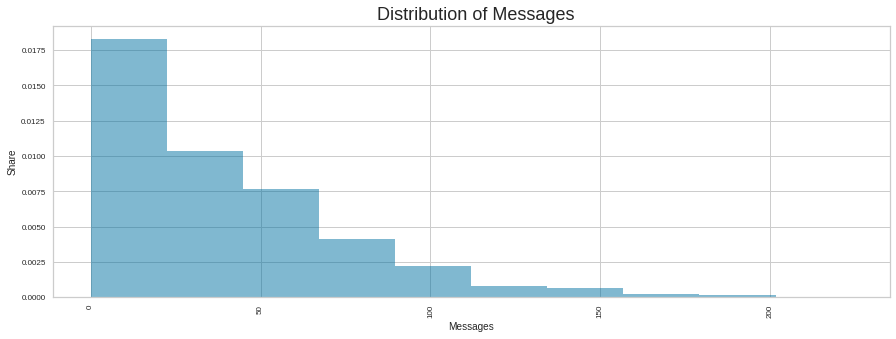

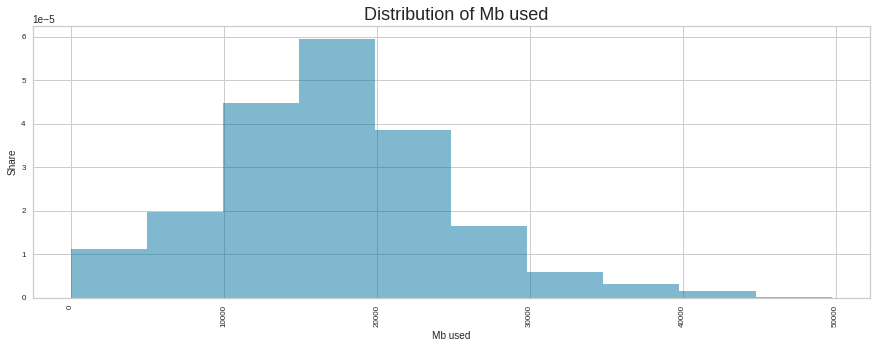

In [10]:
for column in df.columns:
    if df[column].dtype == 'float':
        show_hist_loat_chart(df, column)

## Kurtosis test

Since normal distributions have a kurtosis of 3, excess kurtosis is calculating by subtracting kurtosis by 3.

In [11]:
kurtosis_scipy = stats.kurtosis(df)
kurtosis_pandas = pd.DataFrame(df).kurtosis()[0]

print(kurtosis_scipy, kurtosis_pandas)

[ 1.02469886  0.92465808  1.99462495  0.81961798 -1.29515364] 1.0281639203874584


### Conclusion:
All 4 features have a kurtosis less than 3.  So we know the data is not normal

## Skewness test

skewness = 0 : normally distributed.
skewness > 0 : more weight in the left tail of the distribution.
skewness < 0 : more weight in the right tail of the distribution. 
If the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed

In [12]:
skew_scipy = stats.skew(df)
skew_pandas = pd.DataFrame(df).skew()[0]

print(skew_scipy, skew_pandas)

[0.60608928 0.60756754 1.29516062 0.42989028 0.83955129] 0.6063723123433685


### Conclusion:
Two variables are severely skewed.  The whole dataframe is very skewed.

## Visualize outliers
One of the model that I will use is logistic regression.  This model is known to be very sensitive to outliers.

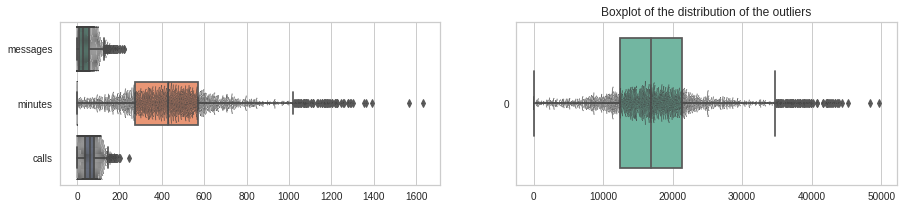

In [13]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
sns.boxplot(data = df.loc[:, ['messages', 'minutes', 'calls']], orient="h", palette="Set2", ax = axs[0])
sns.swarmplot(data = df.loc[:, ['messages', 'minutes', 'calls']], orient="h", color=".25", size=1, ax = axs[0])
sns.boxplot(data = df ['mb_used'], orient="h", palette="Set2", ax = axs[1])
sns.swarmplot(data = df ['mb_used'], orient="h", color=".25", size=1, ax = axs[1])
plt.title("Boxplot of the distribution of the outliers")

plt.show()


## Removing outliers at 3 standard deviations from the mean

In [14]:
df.shape

(3214, 5)

We are starting with a df of 3214 observations

### Feature name: mb_used

In [15]:
q_low = df["mb_used"].quantile(0.01)
q_hi  = df["mb_used"].quantile(0.99)

df  = df[(df["mb_used"] < q_hi) & (df["mb_used"] > q_low)] 
df.shape

(3148, 5)

We lost 66 outlier-observations by dropping those users with mb_used that are 3 std deviations away from the mean.

### Feature name: minutes

In [16]:
q_low = df["minutes"].quantile(0.01)
q_hi  = df["minutes"].quantile(0.99)

df  = df[(df["minutes"] < q_hi) & (df["minutes"] > q_low)] 
df.shape

(3078, 5)

We lost an addition 70 outlier-observations by dropping those users with minutes that are 3 std deviations away from the mean

### Feature name: messages

In [17]:
q_low = df["messages"].quantile(0.01)
q_hi  = df["messages"].quantile(0.99)

df  = df[(df["messages"] < q_hi) & (df["messages"] > q_low)] 
df.shape

(2574, 5)

This is our most important loss sofar.  We lost 504 outlier-observations by dropping those users with message that are 3 std deviations away from the mean

### Feature name: calls

In [18]:
q_low = df["calls"].quantile(0.01)
q_hi  = df["calls"].quantile(0.99)

df  = df[(df["calls"] < q_hi) & (df["calls"] > q_low)] 
df.shape

(2515, 5)

We lost 59 outlier-observations by dropping those users with calls that are 3 std deviations away from the mean.  We are left with 2459 observations.  A total loss of 699 observations or 77.7\% of the data.

## Boxplots of outliers after dropping 3 standard deviations

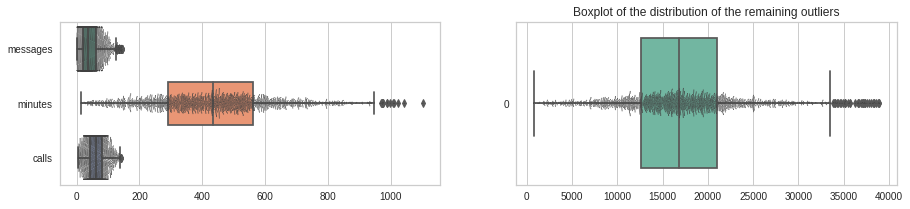

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
sns.boxplot(data = df.loc[:, ['messages', 'minutes', 'calls']], orient="h", palette="Set2", ax = axs[0])
sns.swarmplot(data = df.loc[:, ['messages', 'minutes', 'calls']], orient="h", color=".25", size=1, ax = axs[0])
sns.boxplot(data = df ['mb_used'], orient="h", palette="Set2", ax = axs[1])
sns.swarmplot(data = df ['mb_used'], orient="h", color=".25", size=1, ax = axs[1])
plt.title("Boxplot of the distribution of the remaining outliers")

plt.show()

## The target variable of interest

In [20]:
def show_bar_chart(dataframe: pd.core.frame.DataFrame, column_name: int):
    bar_data = dataframe[column_name].value_counts(normalize=True).head(10)

    bar_data.plot(
        kind='bar', figsize=(15, 5), rot=90, alpha=.5, fontsize=12
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f' Share of {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=14)
    plt.xlabel(beautify_column_name, fontsize=14)

    for i, (x, y) in enumerate(bar_data.to_dict().items()):
        plt.text(i-.15, y, s=str(round(y, 2)), fontsize=12)

    plt.show()

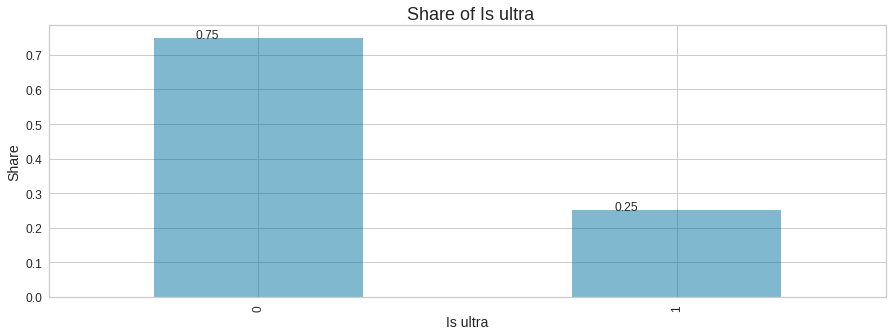

In [21]:
for column in df.columns:
    if df[column].dtype == 'int':
        show_bar_chart(df, column)

## Conclusion:
The target variable is imbalanced.  The models we will be using have all been created for balanced labels.  However, a 70/30 imbalance is not considered as problematic as the one we have in more extreme cases. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# Preparing the data for modelling

## Shuffle in case the data is sorted

In [22]:
df = df.sample(frac=1)

## Splitting the data
https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

- Training data. This type of data builds up the machine learning algorithm. The data scientist feeds the algorithm input data, which corresponds to an expected output. The model evaluates the data repeatedly to learn more about the data’s behavior and then adjusts itself to serve its intended purpose.

- Validation data. During training, validation data infuses new data into the model that it hasn’t evaluated before. Validation data provides the first test against unseen data, allowing data scientists to evaluate how well the model makes predictions based on the new data. Not all data scientists use validation data, but it can provide some helpful information to optimize hyperparameters, which influence how the model assesses data.

- Test data. After the model is built, testing data once again validates that it can make accurate predictions. If training and validation data include labels to monitor performance metrics of the model, the testing data should be unlabeled. Test data provides a final, real-world check of an unseen dataset to confirm that the ML algorithm was trained effectively.

## Stratified sampling:
Ensures the sample drawn is representative of the population it is drawn from
https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213

In [23]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [24]:
df_train, df_val, df_test = \
    split_stratified_into_train_val_test(df, stratify_colname='is_ultra', frac_train=0.60, frac_val=0.20, frac_test=0.20)
df_train.shape

(1509, 5)

In [25]:
X_train = df_train.drop("is_ultra", axis = 1)
y_train = df_train["is_ultra"]
X_valid = df_val.drop("is_ultra", axis = 1)
y_valid = df_val["is_ultra"]
X_test = df_test.drop("is_ultra", axis = 1)
y_test = df_test["is_ultra"]
X_train.shape

(1509, 4)

## RobustScaler
This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

Compare scalers
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

### X training set

In [26]:
scaler = preprocessing.RobustScaler()
robust_X_train = scaler.fit_transform(X_train)

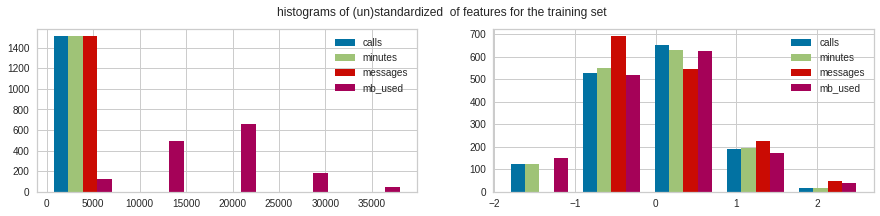

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
fig.suptitle("histograms of (un)standardized  of features for the training set")
axs[1].hist(robust_X_train, bins=5)
axs[0].hist(X_train, bins=5)
axs[0].legend(labels= ['calls','minutes','messages','mb_used'])
axs[1].legend(labels= ['calls','minutes','messages','mb_used'])
plt.show()

### X testing set

In [28]:
robust_X_test = scaler.fit_transform(X_test)

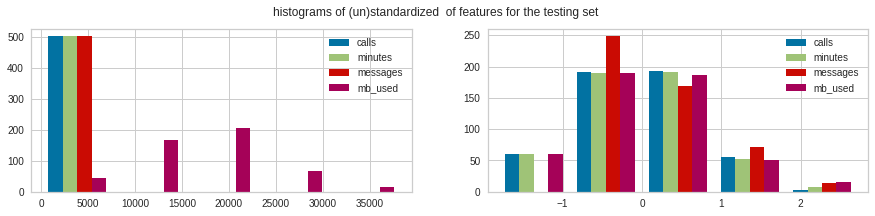

In [29]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
fig.suptitle("histograms of (un)standardized  of features for the testing set")
axs[1].hist(robust_X_test, bins=5)
axs[0].hist(X_test, bins=5)
axs[0].legend(labels= ['calls','minutes','messages','mb_used'])
axs[1].legend(labels= ['calls','minutes','messages','mb_used'])
plt.show()

### X valid set

In [30]:
robust_X_valid = scaler.fit_transform(X_valid)

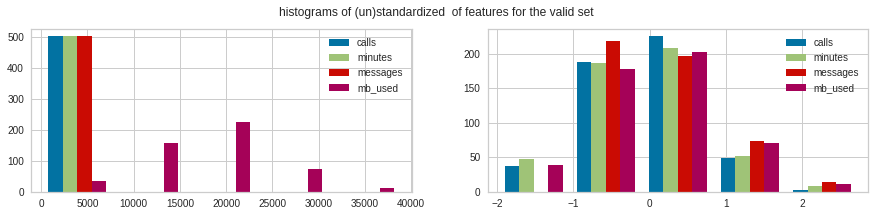

In [31]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
axs[1].hist(robust_X_valid, bins=5)
axs[0].hist(X_valid, bins=5)
axs[0].legend(labels= ['calls','minutes','messages','mb_used'])
axs[1].legend(labels= ['calls','minutes','messages','mb_used'])
fig.suptitle("histograms of (un)standardized  of features for the valid set")
plt.show()

## Conclusion: 
Using the robust scaler transformed the features into a normalish distribution.

# Modeling

## Model 1: 
Using mode as a basic model using mode and a vanilla logistic regression models

In [32]:
mode_class = y_train.mode()[0]
print("The most frequent label is", mode_class)

y_vanilla = np.full(shape=y_train.shape, fill_value=mode_class)
accuracy_score(y_train, y_vanilla)

The most frequent label is 0


0.7481776010603048

In [33]:
# Fit a vanilla Logistic Regression classifier and make predictions

clf = LogisticRegression(max_iter=1000)
clf.fit(X_valid, y_valid)
y_pred_test = clf.predict(X_test)
accuracy_score(y_valid, y_pred_test)

0.7196819085487077

## Conclusion: 
This is the model we need to improve on.  It is actually quite good already. It is definite;y better than 50\%, but we will try to get a better model.

## Model 2: Logistic Regression

Logistic regression is as statistical linear regression model used as a classification model because its output is binary.  The logistic function transforms a linear combination of the input into a non-linear output.  It comes with several assumptions.
This model has several assumptions:
    - The logistic regression assumes that there is minimal or no multicollinearity among the independent variables.
    
    - The Logistic regression assumes that the independent variables are linearly related to the log of odds. no multicollinearity.
    - There are no extreme outliers.
    - The logistic regression usually requires a large sample size to predict properly.
    - The Logistic regression which has two classes assumes that the dependent variable is binary and ordered logistic regression requires the dependent variable to be ordered.
    - The Logistic regression assumes the observations to be independent of each other.
    - There is a linear relationship between features on one side and response on the other.

### Fitting the baseline without scaling

In [34]:
LR = LogisticRegression(random_state=12345, max_iter=10000, penalty='none')
LR.fit(X_train, y_train)     
bl_lr_y_pred = LR.predict(X_valid)
acc_LR = round(accuracy_score(y_valid,bl_lr_y_pred) * 100, 2)
print("Baseline logistic regression model without scaling has an accuracy of",  acc_LR) 

Baseline logistic regression model without scaling has an accuracy of 77.73


#### Conclusion:
This poor model performs worse than the naive mode model

### Fitting the baseline with scaling

In [35]:
LR_rb = LogisticRegression(random_state=12345, max_iter=10000, penalty='none')
LR_rb.fit(robust_X_train, y_train)     
bl_lr_y_pred_rb = LR_rb.predict(robust_X_valid)
acc_LR_rb = round(accuracy_score(y_valid,bl_lr_y_pred_rb) * 100, 2)
print("Baseline logistic regression model with scaling has an accuracy of",  acc_LR_rb) 

Baseline logistic regression model with scaling has an accuracy of 77.34


#### Conclusion:
The robust scaling improves on the performance of the baseline logistic regression.

### Finetuning Hyperparameters

#### Without scaling

In [36]:
grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=12345)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("coefficient: ", logreg_cv.best_estimator_.coef_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
accuracy : 0.7786666666666667
coefficient:  [[-1.27654648e-03  1.64431423e-03  1.47777401e-02  4.98044074e-05]]


#### Validation

In [37]:
LR = LogisticRegression(random_state=12345, C = 0.001, penalty='l2', solver = 'newton-cg')
LR.fit(X_train, y_train)     
lr_y_pred = LR.predict(X_valid)
acc_LR = round(accuracy_score(y_valid,lr_y_pred) * 100, 2)
print("Baseline logistic regression model with scaling has an accuracy of",  acc_LR) 

Baseline logistic regression model with scaling has an accuracy of 77.73


#### With scaling

In [38]:
grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=12345)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(robust_X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("coefficient: ", logreg_cv.best_estimator_.coef_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.7793289183222958
coefficient:  [[-0.00222032  0.39788262  0.63152294  0.41926062]]


#### Validation

In [39]:
LR_rb = LogisticRegression(random_state=12345, C = 10, penalty='l1', solver = 'liblinear')
LR_rb.fit(robust_X_train, y_train)     
lr_y_pred_rb = LR_rb.predict(robust_X_valid)
acc_LR_rb = round(accuracy_score(y_valid,lr_y_pred_rb) * 100, 2)
print("Baseline logistic regression model with scaling has an accuracy of",  acc_LR_rb) 

Baseline logistic regression model with scaling has an accuracy of 77.34


#### Conclusion: 
Curiously, the robust variables do not improve on the original unscaled variables.  But the finetuning of the logistic regression model slightly improved on the naive, 2\%.  In both instances, messages and minutes were the two most influential features followed by mb_used to predict is_ultra.  

## Model 3: Decision Tree

### Fitting the baseline without scaling

In [40]:
decision_tree = DecisionTreeClassifier(random_state=12345)
decision_tree.fit(X_train, y_train);
bl_dt_y_pred = decision_tree.predict(X_valid)
acc_decision_tree = round(accuracy_score(y_valid, bl_dt_y_pred) * 100, 2)
print("Baseline decision tree has an accuracy of",  acc_decision_tree) 

Baseline decision tree has an accuracy of 74.16


### Fitting the baseline with scaling

In [41]:
decision_tree_st = DecisionTreeClassifier(random_state=12345)
decision_tree_st.fit(robust_X_train, y_train);
bl_dt_y_pred_rb = decision_tree_st.predict(robust_X_valid)
acc_decision_tree = round(accuracy_score(y_valid,bl_dt_y_pred_rb) * 100, 2)
print("Baseline decision tree has an accuracy of",  acc_decision_tree) 

Baseline decision tree has an accuracy of 73.56


#### Conclusion:
Baseline decision tree models do not improve on naive model.  

### Finetuning Hyperparameters

#### Without scaling

In [42]:
for depth in range(1,11):
    decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_valid)
    acc_dt = round(accuracy_score(y_valid,y_pred) * 100, 2)
    print("max_depth =", depth, ":", acc_dt) 

max_depth = 1 : 77.73
max_depth = 2 : 79.92
max_depth = 3 : 80.72
max_depth = 4 : 79.92
max_depth = 5 : 78.93
max_depth = 6 : 79.13
max_depth = 7 : 80.12
max_depth = 8 : 80.52
max_depth = 9 : 79.13
max_depth = 10 : 76.14


#### Validation

In [43]:
decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=10)
decision_tree.fit(X_train, y_train);
dt_y_pred = decision_tree.predict(X_valid)
acc_decision_tree = round(accuracy_score(y_valid,dt_y_pred) * 100, 2)

print("Best tuned decision tree model has an accuracy of", acc_decision_tree) 

Best tuned decision tree model has an accuracy of 76.14


#### With scaling

In [44]:
for depth in range(1,11):
    decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_tree.fit(robust_X_train, y_train)
    y_pred = decision_tree.predict(robust_X_valid)
    acc_dt = round(accuracy_score(y_valid,y_pred) * 100, 2)
    print("max_depth =", depth, ":", acc_dt) 

max_depth = 1 : 76.34
max_depth = 2 : 78.33
max_depth = 3 : 79.32
max_depth = 4 : 79.13
max_depth = 5 : 78.13
max_depth = 6 : 78.33
max_depth = 7 : 78.13
max_depth = 8 : 78.73
max_depth = 9 : 76.34
max_depth = 10 : 76.54


In [45]:
decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=5)
decision_tree.fit(robust_X_train, y_train);
dt_y_pred_rb = decision_tree.predict(robust_X_valid)
acc_decision_tree_rb = round(accuracy_score(y_valid,dt_y_pred_rb) * 100, 2)
print("Best tuned decision tree model has an accuracy of", acc_decision_tree_rb) 

Best tuned decision tree model has an accuracy of 78.13


##### Conclusion:
Finally we have an improvement on the mode model of prediction.  Ironically, the non scaled model performs better.

## Model 4: Random Forest

### Fitting the baseline without scaling

In [46]:
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(X_train, y_train);
bl_rf_y_pred = rfc.predict(X_valid)
acc_rfc = round(accuracy_score(y_valid,bl_rf_y_pred) * 100, 2)
print("baseline random forest without scaling has an accuracy =",  acc_rfc) 

baseline random forest without scaling has an accuracy = 80.12


### Fitting the baseline with scaling

In [47]:
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(robust_X_train, y_train);
bl_rf_y_pred_rb = rfc.predict(robust_X_valid)
acc_rfc_rb = round(accuracy_score(y_valid,bl_rf_y_pred_rb) * 100, 2)
print("baseline random forest with scaling has an accuracy =",  acc_rfc_rb) 

baseline random forest with scaling has an accuracy = 78.53


#### Conclusion:
Here in the baselines, the scaled model performs better.

### Finetuning the Hyperparameters

#### Without scaling

In [48]:
d_rf = []
for est in range(1,50,5):
    for depth in range(1,20):
        rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_valid)
        acc_rfc = round(accuracy_score(y_valid,y_pred) * 100, 2)
        d_rf.append(
            {
                'n_estimators': est,
                'max_depth': depth,
                'acc_rfc':  acc_rfc
            }
        )

best_param = pd.DataFrame(d_rf).nlargest(5, ['acc_rfc'], keep='first')
best_param

,n_estimators,max_depth,acc_rfc
180,46,10,81.71
27,6,9,81.51
56,11,19,81.51
161,41,10,81.51
25,6,7,81.31


#### Validation

In [49]:
rfc = RandomForestClassifier(n_estimators = 16, max_depth = 9, random_state=12345)
rfc.fit(X_train, y_train)
rf_y_pred = rfc.predict(X_valid)
acc_rfc = round(accuracy_score(y_valid,rf_y_pred) * 100, 2)
print("Best tuned random forest model: max_depth =", depth, "and accuracy", acc_rfc) 

Best tuned random forest model: max_depth = 19 and accuracy 80.91


#### With scaling

In [50]:
d_rf = []
for est in range(1,50,5):
    for depth in range(1,20):
        rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        rfc.fit(robust_X_train, y_train)
        y_pred = rfc.predict(robust_X_valid)
        acc_rfc = round(accuracy_score(y_valid,y_pred) * 100, 2)
        d_rf.append(
            {
                'n_estimators': est,
                'max_depth': depth,
                'acc_rfc':  acc_rfc
            }
        )

best_param = pd.DataFrame(d_rf).nlargest(5, ['acc_rfc'], keep='first')
best_param

,n_estimators,max_depth,acc_rfc
27,6,9,81.51
24,6,6,81.11
44,11,7,81.11
47,11,10,81.11
159,41,8,81.11


#### Validation

In [51]:
rfc_robust = RandomForestClassifier(n_estimators = 21, max_depth = 14, random_state=12345)
rfc_robust.fit(robust_X_train, y_train)
rf_y_pred_rb = rfc_robust.predict(robust_X_valid)
acc_rfc = round(accuracy_score(y_valid,rf_y_pred_rb) * 100, 2)
print("Best tuned random forest model: max_depth =", depth, "and accuracy", acc_rfc) 

Best tuned random forest model: max_depth = 19 and accuracy 80.32


### Conclusion:
The best accuracy for the random forest is again the non scaled model.

# Metrics

PLEASE HELP ME WRITE THIS IN A LOOP

In [52]:
true = y_test
target_names = ["Surf", "Ultra"]


clf_report1 = classification_report(true,
                                   bl_lr_y_pred,
                                   target_names=target_names, 
                                   output_dict=True)
clf_report2 = classification_report(true,
                                   bl_lr_y_pred_rb,
                                   target_names=target_names,
                                   output_dict=True)
clf_report3 = classification_report(true,
                                   lr_y_pred,
                                   target_names=target_names,
                                   output_dict=True)
clf_report4 = classification_report(true,
                                   lr_y_pred_rb,
                                   target_names=target_names,
                                   output_dict=True)
clf_report5 = classification_report(true,
                                   bl_dt_y_pred,
                                   target_names=target_names,
                                   output_dict=True)
clf_report6 = classification_report(true,
                                   bl_dt_y_pred_rb,
                                   target_names=target_names,
                                   output_dict=True)
clf_report7 = classification_report(true,
                                   dt_y_pred,
                                   target_names=target_names,
                                   output_dict=True)
clf_report8 = classification_report(true,
                                   dt_y_pred_rb,
                                   target_names=target_names,
                                   output_dict=True)
clf_report9 = classification_report(true,
                                   bl_rf_y_pred,
                                   target_names=target_names,
                                   output_dict=True)
clf_report10 = classification_report(true,
                                   bl_rf_y_pred_rb,
                                   target_names=target_names,
                                   output_dict=True)
clf_report11 = classification_report(true,
                                   rf_y_pred,
                                   target_names=target_names,
                                   output_dict=True)
clf_report12 = classification_report(true,
                                   rf_y_pred_rb,
                                   target_names=target_names,
                                   output_dict=True)

In [62]:
# something like that?
# reviewer's example
for i in ['model_1', 'model_2']:
    print(f"{i} classification_report")
    print(classification_report(true, rf_y_pred_rb, target_names=target_names))

model_1 classification_report
              precision    recall  f1-score   support

        Surf       0.75      0.84      0.79       376
       Ultra       0.28      0.18      0.22       127

    accuracy                           0.67       503
   macro avg       0.51      0.51      0.51       503
weighted avg       0.63      0.67      0.65       503

model_2 classification_report
              precision    recall  f1-score   support

        Surf       0.75      0.84      0.79       376
       Ultra       0.28      0.18      0.22       127

    accuracy                           0.67       503
   macro avg       0.51      0.51      0.51       503
weighted avg       0.63      0.67      0.65       503



PLEASE HELP ME WRITE A LOOP HERE

In [ ]:
# something like that?
# reviewer's example

In [68]:
clf_rep_lst = []
clf_rep_lst.append(clf_report1)
clf_rep_lst.append(clf_report2)
clf_rep_lst.append(clf_report3)
clf_rep_lst.append(clf_report4)
clf_rep_lst.append(clf_report5)
clf_rep_lst.append(clf_report6)
clf_rep_lst.append(clf_report7)
clf_rep_lst.append(clf_report8)
clf_rep_lst.append(clf_report9)
clf_rep_lst.append(clf_report10)
clf_rep_lst.append(clf_report11)
clf_rep_lst.append(clf_report12)

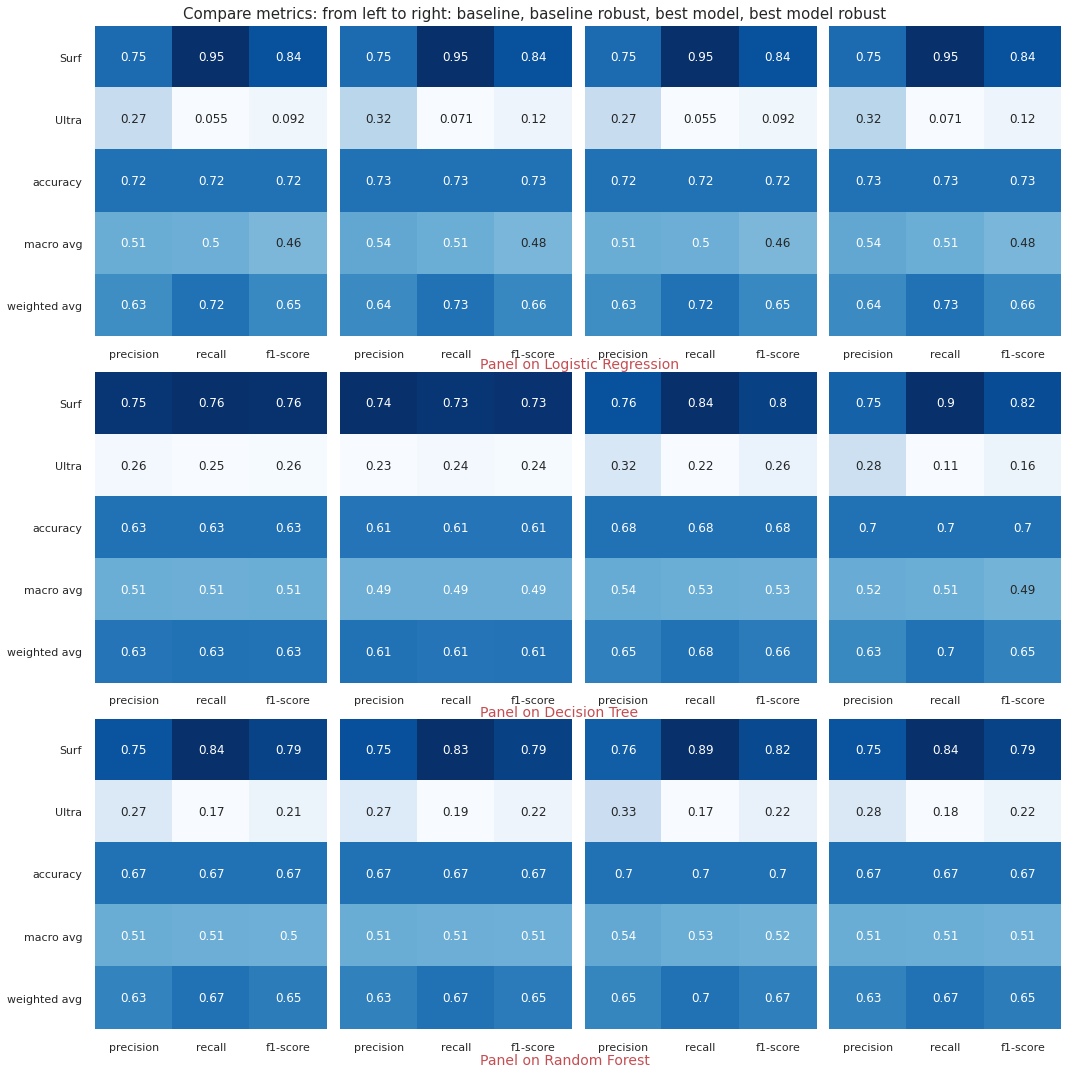

In [69]:
sns.set()
fig,axes = plt.subplots(3, 4, figsize=(15, 15), sharey=True)


fig.suptitle('Compare metrics: from left to right: baseline, baseline robust, best model, best model robust', fontsize=15)
plt.figtext(.45,.645, "Panel on Logistic Regression", fontsize=14, color="r")
plt.figtext(.45,.323, "Panel on Decision Tree", fontsize=14, color="r")
plt.figtext(.45,.001, "Panel on Random Forest", fontsize=14, color="r")

for i in range(12):
    sns.heatmap(pd.DataFrame(clf_rep_lst[i]).iloc[:-1, :].T, 
                cmap = "Blues", annot=True, cbar = False, ax = axes.flat[i])
    
plt.tight_layout()

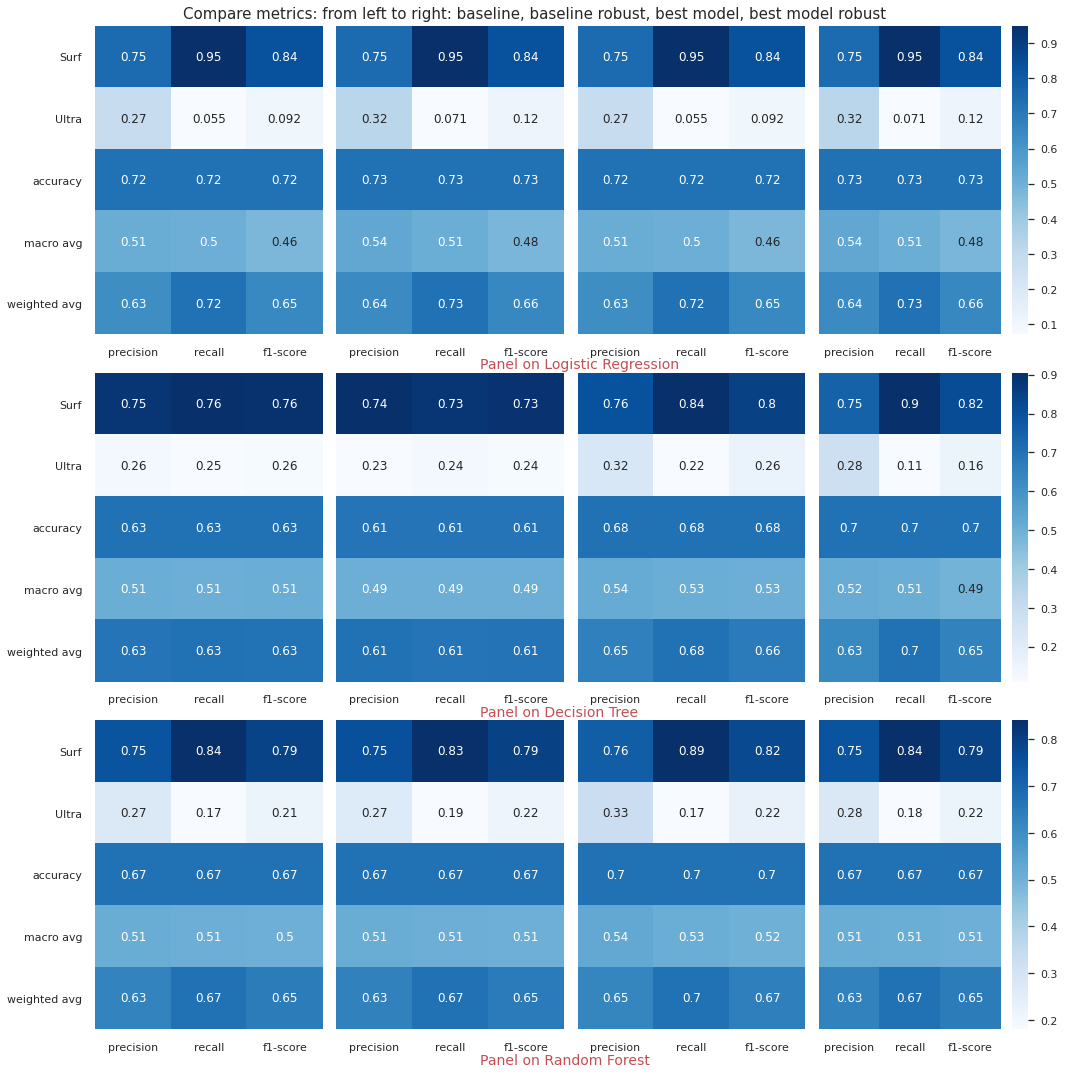

In [53]:
# .iloc[:-1, :] to exclude support
sns.set()
fig,axes = plt.subplots(3, 4, figsize=(15, 15), sharey=True)


fig.suptitle('Compare metrics: from left to right: baseline, baseline robust, best model, best model robust', fontsize=15)
plt.figtext(.45,.645, "Panel on Logistic Regression", fontsize=14, color="r")
plt.figtext(.45,.323, "Panel on Decision Tree", fontsize=14, color="r")
plt.figtext(.45,.001, "Panel on Random Forest", fontsize=14, color="r")
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False, ax = axes.flat[0])
sns.heatmap(pd.DataFrame(clf_report2).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False,ax=axes.flat[1])
sns.heatmap(pd.DataFrame(clf_report3).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False,ax=axes.flat[2])
sns.heatmap(pd.DataFrame(clf_report4).iloc[:-1, :].T,cmap = "Blues", annot=True, ax=axes.flat[3])
sns.heatmap(pd.DataFrame(clf_report5).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False,ax=axes.flat[4])
sns.heatmap(pd.DataFrame(clf_report6).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False,ax=axes.flat[5])
sns.heatmap(pd.DataFrame(clf_report7).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False,ax=axes.flat[6])
sns.heatmap(pd.DataFrame(clf_report8).iloc[:-1, :].T,cmap = "Blues", annot=True, ax=axes.flat[7])
sns.heatmap(pd.DataFrame(clf_report9).iloc[:-1, :].T,cmap = "Blues", annot=True, cbar = False,ax=axes.flat[8])
sns.heatmap(pd.DataFrame(clf_report10).iloc[:-1, :].T,cmap = "Blues", annot=True,cbar = False,ax=axes.flat[9])
sns.heatmap(pd.DataFrame(clf_report11).iloc[:-1, :].T,cmap = "Blues", annot=True,cbar = False, ax=axes.flat[10])
sns.heatmap(pd.DataFrame(clf_report12).iloc[:-1, :].T,cmap = "Blues", annot=True, ax=axes.flat[11])
plt.tight_layout()

# Thought Process:

- Mobile carrier Megaline is unhappy with the fact that many of its customers are using legacy plans. They want to develop a model that can analyze customer behavior and recommend one of Megaline's newer plans: Surf or Ultimate.
- I understand a legacy plan to be unlimited data, calls, messages.  So, the minutes feature is not part of legacy plan since calls are unlimited.
- I have found from the linear logistic regression that messages was the feature that best predicted whether a customer is using an Ultra of Surf plan based on the value of its coefficient.  Also based on the value of the coefficient, minutes were not that important indeed.
- I also assume that the company wants to maximize its profit.  We know from previous projects that it is the Surf plan that is most profitable because of all the overages.  So what we care about the most is the TRUE POSITIVES (TP) of Surf.  We also know that the plan Surf has 70\% share of the Megaline customers in the dataset.  So there is an imbalance in the target variable.
- Therefore, we are interested in a model that correctly classifies customer behavior (messages, calls and mb_used, in that order) into the Surf plan.
- To translate, we want the model with the highest accuracy, followed by both precision and recall because the positive cases matter the most.  This can also be summarized by F1.
- Both precision and recall are crucial for information retrieval, where positive class mattered the most as compared to negative.
- Precision: Out of all the positive predicted, what percentage is truly positive.
- Recall: Out of the total positive, what percentage are predicted positive. It is the same as TPR (true positive rate).
- F1: It is the harmonic mean of precision and recall. It takes both false positive and false negatives into account. Therefore, it performs well on an imbalanced dataset.
- The receiver operating characteristic (ROC) curve is frequently used for evaluating the performance of binary classification algorithms. It --provides a graphical representation of a classifier’s performance, rather than a single value like most other metrics. AUC stands for area under the (ROC) curve.  Generally, the higher the AUC score, the better a classifier performs for the given task.
- Testing the models on the testing set revealed that they were overfitted.  The accuracy dropped significantly, but the recall of Surf remains the best due to our original imbalance, I assume.
- By looking at all the mterics above, the basic untuned logistic regression is the best model.  The next best is the random forest model without scaling.
- After choosing the best 2 models based on these criteria, I will use the ROC curve to select the best model based on the curve. 

# ROC and AUC

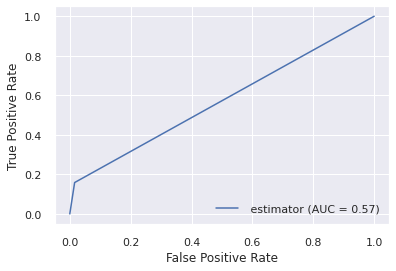

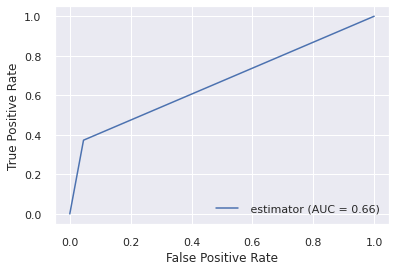

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, bl_lr_y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name=' estimator')
display.plot()


fpr, tpr, thresholds = metrics.roc_curve(y_valid, rf_y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name=' estimator')

display.plot();



# Conclusion:
The AUC of the random forest is better than that of the baseline logistic regression.  The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.  This means that the random forest is better at distinguishing between Ultra and Surf.

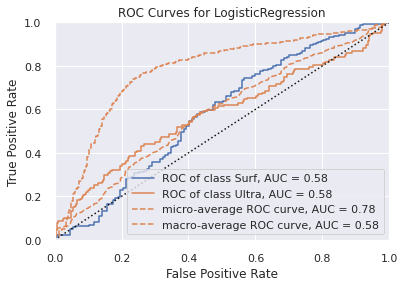

In [55]:
# Instantiate the visualizer with the classification model
model1 = LR
visualizer = ROCAUC(model1, classes=["Surf", "Ultra"])

visualizer.fit(robust_X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(robust_X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  ;

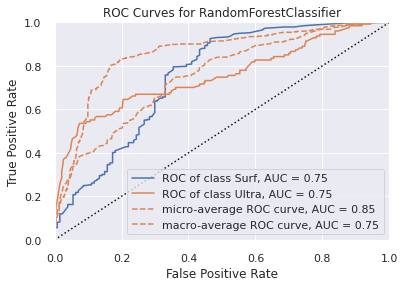

In [56]:
# Instantiate the visualizer with the classification model
model2 = rfc
visualizer = ROCAUC(model2, classes=["Surf", "Ultra"])

visualizer.fit(robust_X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(robust_X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  ;                     # Finalize and show the figure

# Sanity check

Compared to the 75\% performance of the mode model, none of my models compare.  The accuracy of the baseline logistic regression without scaling is at most similar to the mode classifer

# Conclusion:
- All models cannot predict Ultra well.
- Scaling did not help.
- Logistic regressions are the best for predict Surf, which is indeed our plan of interest.
- The tuned decision tree models also fared well with regards to our plan of interest.
- The tuned random forest were the best at predicting our plan of interest while doing better at predicting the imbalanced label Ultra.  That is not surprising given that they had the best accuracy scores
- the AUC curve shows us that the macro of the non robust random forest is better than that of the regular random forest.  But a closer look at both ROC and AUC show us that, at least as far our prediction of interest goes, Surf, the robust model is indeed superior.
- Our final model has an accuracy of 82\% much higher than the 75\% of the naive mode model that we first tested.